In [1]:
import os
import cv2

import numpy as np
import matplotlib.pyplot as plt

import time
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
!pip show matplotlib

Name: matplotlib
Version: 3.6.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /opt/conda/lib/python3.10/site-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, beatrix-jupyterlab, Cartopy, catboost, cleverhans, contextily, descartes, explainable-ai-sdk, fastai, fitter, geoplot, ggplot, hypertools, imgaug, ipympl, ipyvolume, lime, matplotlib-venn, missingno, mizani, mlxtend, mne, mpld3, osmnx, phik, plotnine, pointpats, prophet, PyUpSet, scikit-plot, seaborn, segregation, splot, vaex-viz, vtk, wfdb, wordcloud, ydata-profiling, yellowbrick


In [3]:
!pip install split-folders
!pip install visualkeras
import visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 15.4 MB/s eta 0:00:00a 0:00:01


In [4]:
import splitfolders 
import visualkeras
splitfolders.ratio("/kaggle/input/agronify-dataset/Ripeness/Ripeness/Pisang", 
                   output="Pisang-data", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 

Copying files: 6194 files [00:26, 230.29 files/s]


In [5]:
training_dir = os.path.join('Pisang-data', 'train')
testing_dir = os.path.join('Pisang-data', 'test')
validating_dir = os.path.join('Pisang-data', 'val')

In [6]:
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    shuffle=True,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
    validating_dir,
    target_size=(224,224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

testing_generator = validation_datagen.flow_from_directory(
    testing_dir,
    target_size=(224, 224),
    shuffle=True,
    class_mode='categorical',
    batch_size=32
)

Found 4335 images belonging to 2 classes.
Found 1238 images belonging to 2 classes.
Found 621 images belonging to 2 classes.


In [8]:
class_indices = train_generator.class_indices
print(class_indices)
class_names = list(class_indices.keys())
print(class_names)
class_count = len(class_names)

{'Matang': 0, 'Mentah': 1}
['Matang', 'Mentah']


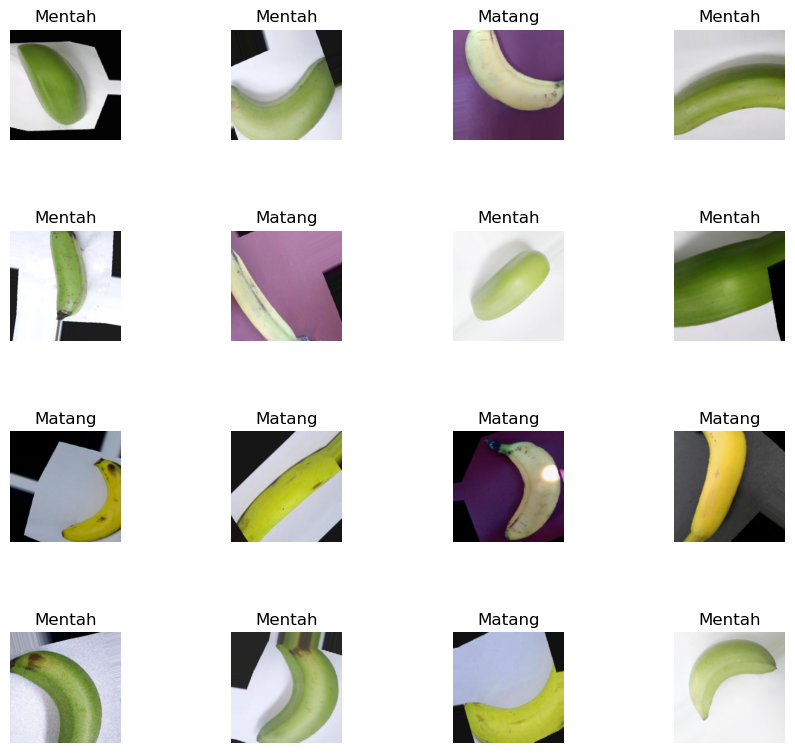

In [9]:
def display_images(images, labels, class_indices):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        label_index = np.argmax(labels[i])
        label = list(class_indices.keys())[list(class_indices.values()).index(label_index)]
        ax.set_title(label)
        plt.subplots_adjust(wspace=1)
        ax.axis('off')

train_images, train_labels = next(train_generator)
display_images(train_images, train_labels, train_generator.class_indices)
plt.show()

In [10]:
class LR_ASK(keras.callbacks.Callback):
    def __init__(self, model, total_epochs, ask_epoch):
        super(LR_ASK, self).__init__()
        self.model = model
        self.ask_epoch = ask_epoch
        self.total_epochs = total_epochs
        self.ask = True
        self.lowest_val_loss = np.inf
        self.best_weights = self.model.get_weights()
        self.best_epoch = 1

    def on_train_begin(self, logs=None):
        if self.ask_epoch == 0:
            print('You set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch = 1
        if self.ask_epoch >= self.total_epochs:
            print('ask_epoch >= total_epochs, will train for', self.total_epochs, 'epochs', flush=True)
            self.ask = False
        if self.total_epochs == 1:
            self.ask = False
        else:
            print('Training will proceed until epoch', self.ask_epoch, 'then you will be asked to')
            print('enter H to halt training or enter an integer for how many more epochs to run then be asked again')
        self.start_time = time.time()

    def on_train_end(self, logs=None):
        print('Loading model with weights from epoch', self.best_epoch)
        self.model.set_weights(self.best_weights)
        training_duration = time.time() - self.start_time
        hours = training_duration // 3600
        minutes = (training_duration - (hours * 3600)) // 60
        seconds = training_duration - ((hours * 3600) + (minutes * 60))
        msg = f'Training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg, flush=True)

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss < self.lowest_val_loss:
            self.lowest_val_loss = val_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
            print(f'\nValidation loss of {val_loss:7.4f} is below the lowest loss, saving weights from epoch {str(epoch + 1):3s} as the best weights')
        else:
            print(f'\nValidation loss of {val_loss:7.4f} is above the lowest loss of {self.lowest_val_loss:7.4f}, keeping weights from epoch {str(self.best_epoch)} as the best weights')

        if self.ask:
            if epoch + 1 == self.ask_epoch:
                print('\nDo you want to continue training (Y/N)?')
                ans = input()

                if ans.lower() == 'n':
                    print('Training halted on epoch', epoch + 1, 'due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += 1

In [11]:
tf.keras.backend.clear_session()
#del model

In [12]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

image_shape = (224, 224, 3)
model_name = 'MobileNet'
base_model = MobileNet(
    include_top=False,
    input_shape=image_shape,
    pooling=None,  # Remove the pooling parameter
    weights='imagenet',

)
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(rate=0.3)(x)

output = Dense(class_count, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)
model.summary()

model.compile(
    Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


17225924/17225924 [==============================] - 0s 0us/step
Number of layers in the base model:  86
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNo

In [13]:
total_epochs = 100
ask_epoch = 20
ask_callback = LR_ASK(model, total_epochs, ask_epoch)
rlronp_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1)
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, verbose=1)
callbacks = [rlronp_callback, ask_callback, earlystop_callback]

In [14]:
training_history = model.fit(train_generator,
                             epochs=total_epochs,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=len(validation_generator),
                             initial_epoch=0)

Training will proceed until epoch 20 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/100
136/136 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9839
Validation loss of  0.0016 is below the lowest loss, saving weights from epoch 1   as the best weights
136/136 [==============================] - 73s 418ms/step - loss: 0.0734 - accuracy: 0.9839 - val_loss: 0.0016 - val_accuracy: 0.9992 - lr: 0.0010
Epoch 2/100
136/136 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9961
Validation loss of  0.0107 is above the lowest loss of  0.0016, keeping weights from epoch 1 as the best weights
136/136 [==============================] - 57s 420ms/step - loss: 0.0110 - accuracy: 0.9961 - val_loss: 0.0107 - val_accuracy: 0.9960 - lr: 0.0010
Epoch 3/100
136/136 [==============================] - ETA: 0s - loss: 0.0083 - accuracy: 0.9982
Validation loss of  0.0013 is below the

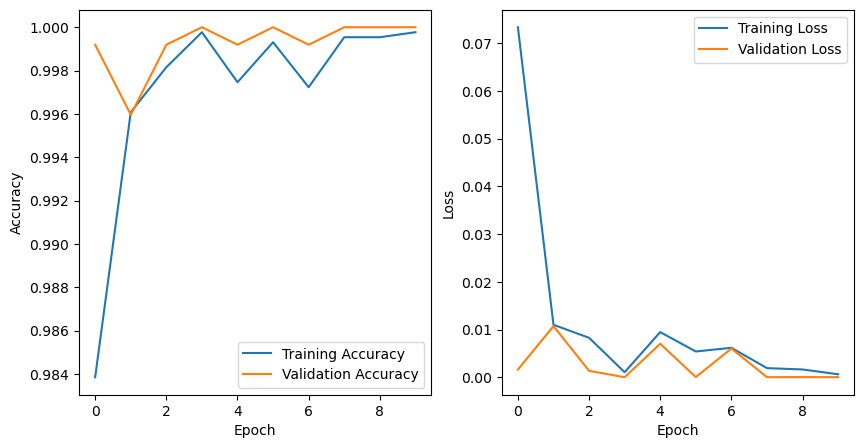

In [18]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
score = model.evaluate(testing_generator, verbose=1)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

20/20 [==============================] - 1s 65ms/step - loss: 3.6990e-07 - accuracy: 1.0000
Test loss: 3.698998796153319e-07 / Test accuracy: 1.0


In [19]:
model.save('PisangPreTrainedFinal.h5')